# PBMC 3k Single-Cell RNA-Seq Analysis
This notebook performs an end-to-end analysis of the 10x PBMC 3k dataset using Scanpy in Python. Steps include preprocessing, dimensionality reduction, clustering, annotation, and visualization.


## Step 1: Setup and Load Dataset
- Load Scanpy
- Read the PBMC 3k dataset

In [4]:
import scanpy as sc

# Load the dataset
adata = sc.read("results/pbmc3k_processed.h5ad")

# Show basic info
adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
import os
os.getcwd()


## Step 2: Preprocessing
- Filter cells and genes
- Normalize and log-transform
- Identify highly variable genes
- Scale and PCA


In [ ]:
# Step 1: Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Step 2: Calculate mitochondrial gene content
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Step 3: Filter out low-quality cells
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Step 4: Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Step 5: Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

# Step 6: Scale and run PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


## Step 3: Clustering and UMAP
- Compute neighbors
- Run UMAP
- Leiden clustering

In [ ]:
# Step 7: Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Step 8: Run UMAP
sc.tl.umap(adata)

# Step 9: Cluster the cells using the Leiden algorithm
sc.tl.leiden(adata)

# Step 10: Plot UMAP with clusters
sc.pl.umap(adata, color=['leiden'])


In [ ]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])


## Step 4: Annotate Cell Types
- Map cluster IDs to biological cell types
- Plot UMAP with annotations

In [ ]:
# Example mapping (you can refine based on your own markers)
cluster_annotations = {
    '0': 'CD14+ Monocytes',
    '1': 'Naive CD4+ T cells',
    '2': 'Memory CD4+ T cells',
    '3': 'B cells',
    '4': 'NK cells',
    '5': 'CD8+ T cells',
    '6': 'FCGR3A+ Monocytes',
    '7': 'Dendritic cells',
    '8': 'Platelets'
}

# Apply annotation
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

# Plot UMAP with cell types
sc.pl.umap(adata, color='cell_type', legend_loc='on data', title='Cell Type Annotation')


In [ ]:
# Rank genes for each cluster (Leiden)
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')  # Or use 'wilcoxon'
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


## Step 5: Marker Genes
- Rank marker genes for each cluster
- Plot heatmaps, violin plots, dot plots

In [ ]:
# Save the UMAP plot
sc.pl.umap(adata, color='cell_type', save='_celltypes.png')

# Save marker gene table
import pandas as pd

# Extract top genes for each cluster
marker_table = sc.get.rank_genes_groups_df(adata, group=None)
marker_table.to_csv("results/marker_genes_by_cluster.csv", index=False)


In [ ]:
sc.pl.violin(adata, ['CD3D', 'MS4A1', 'GNLY', 'CD14'], groupby='cell_type', rotation=45)


In [ ]:
adata.var_names[:20]


In [ ]:
sc.pl.violin(adata, ['TNFRSF4', 'TNFRSF25', 'TNFRSF1B'], groupby='cell_type', rotation=45)


In [ ]:
sc.pl.dotplot(adata, ['TNFRSF4', 'TNFRSF25', 'TNFRSF1B'], groupby='cell_type')


In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='cell_type', show_gene_labels=True)


Groups are not reordered because the `groupby` categories and the `var_group_labels` are different.
categories: 0, 1, 2, etc.
var_group_labels: B cells, CD8+ T cells, CD14+ Monocytes, etc.


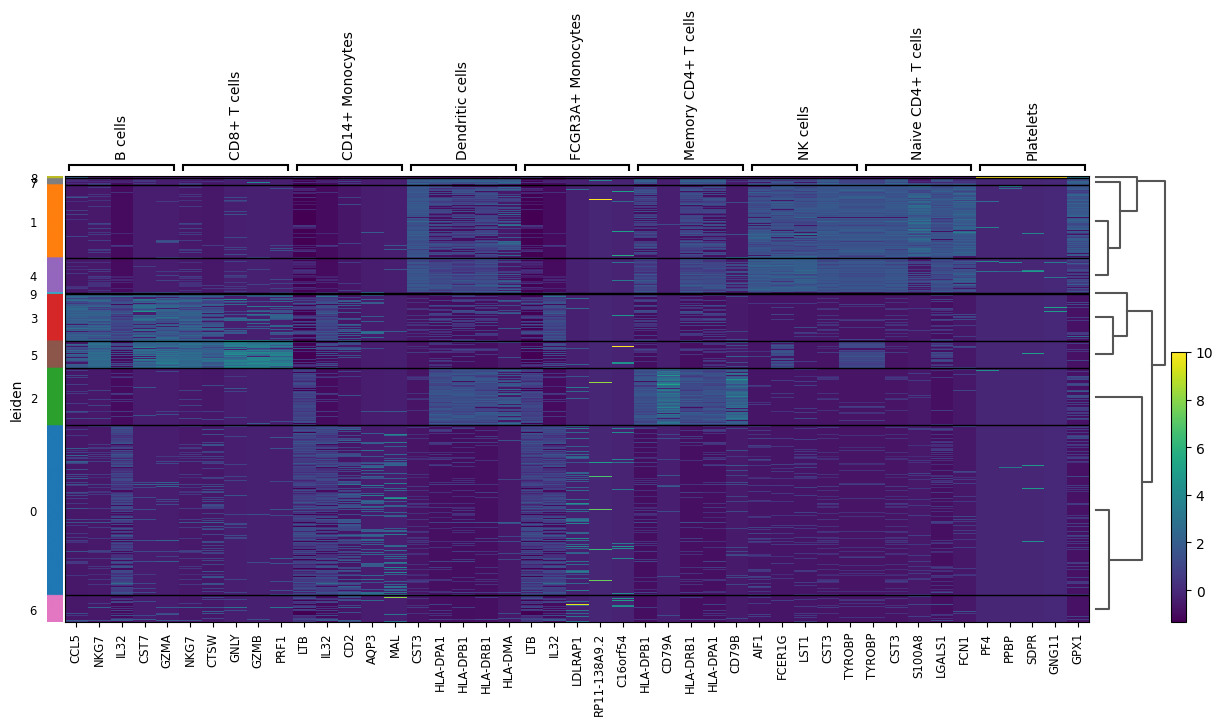

In [5]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='leiden', show_gene_labels=True)


In [ ]:
sc.tl.rank_genes_groups(adata, groupby='cell_type', method='t-test')


## Step 6: Save Outputs
- Save `.h5ad` object
- Save plots
- Export marker gene tables

In [ ]:
adata.write("results/pbmc3k_processed.h5ad")


In [ ]:
sc.pl.umap(adata, color="cell_type", save="_umap_celltypes.png")
sc.pl.dotplot(adata, ['TNFRSF4', 'TNFRSF25'], groupby='cell_type', save="_dotplot.png")
sc.pl.violin(adata, ['TNFRSF1B'], groupby='cell_type', rotation=45, save="_violin.png")


In [ ]:
import pandas as pd
marker_table = sc.get.rank_genes_groups_df(adata, group=None)
marker_table.to_csv("results/marker_genes_by_cluster.csv", index=False)


Groups are not reordered because the `groupby` categories and the `var_group_labels` are different.
categories: 0, 1, 2, etc.
var_group_labels: B cells, CD8+ T cells, CD14+ Monocytes, etc.
saving figure to file figures/heatmap_heatmap.png


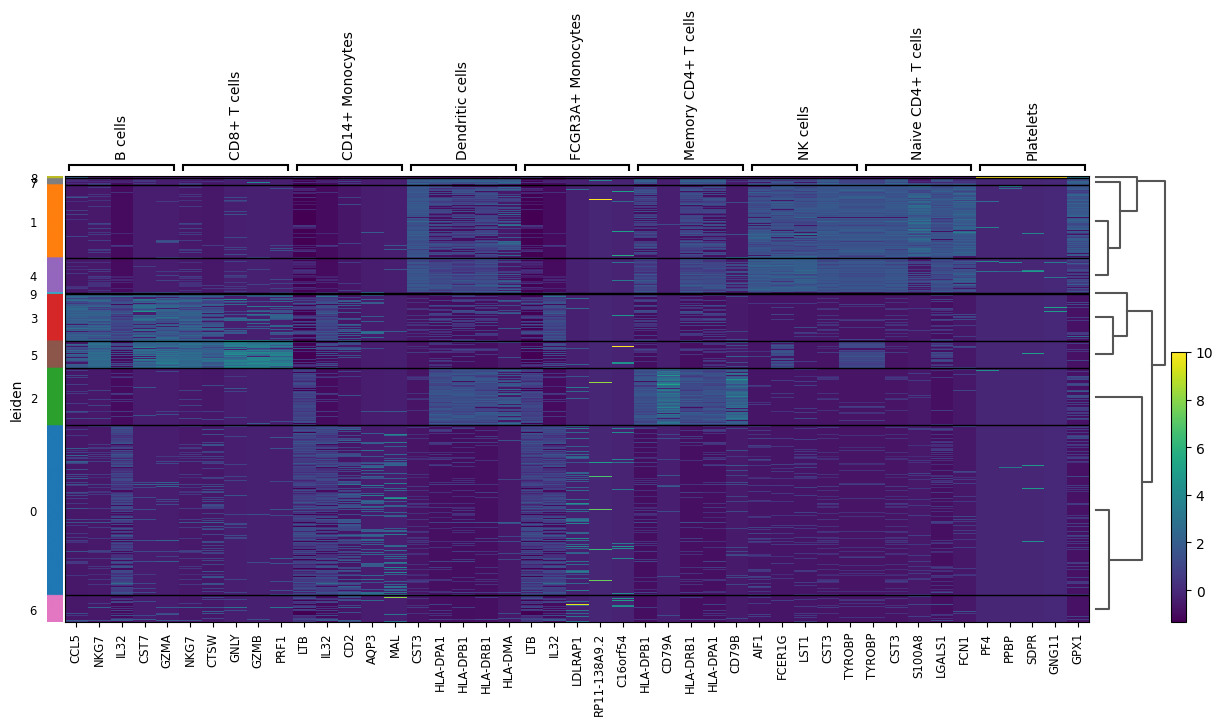

In [6]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='leiden', show=True, save='_heatmap.png')
